In [1]:
# LSTM_Training.ipynb

# Importation des bibliothèques nécessaires
import numpy as np  # Pour les opérations mathématiques sur les tableaux
import pandas as pd  # Pour la manipulation des données sous forme de DataFrame
import matplotlib.pyplot as plt  # Pour créer des graphiques
import yfinance as yf  # Pour récupérer les données boursières en ligne

# Pour normaliser les données (mise à l'échelle entre 0 et 1)
from sklearn.preprocessing import MinMaxScaler

# Importation des modules de Keras pour construire et utiliser des modèles de deep learning
from keras.models import Sequential, load_model  # Pour créer et charger un modèle séquentiel
from keras.layers import LSTM, Dense, Dropout  # Couches LSTM, Dense (classique) et Dropout (réduction du surapprentissage)

# Pour manipuler des dates (calcul de périodes, etc.)
from datetime import datetime, timedelta

In [2]:
# Importation de requests depuis curl_cffi pour effectuer des requêtes HTTP en contournant certaines restrictions (Cloudflare, etc.)
from curl_cffi import requests

# Création d'une session HTTP avec une identification comme navigateur Chrome (pour éviter les blocages)
session = requests.Session(impersonate="chrome")

# Récupération des données boursières pour un ticker spécifique via yfinance en utilisant la session personnalisée
# Remplace les '...' par le symbole réel de l'action (ex: 'AAPL' pour Apple)
ticker = yf.Ticker('...', session=session)

In [3]:
# --------------------------
# PART 1: FETCH DATA
# --------------------------

# Définir la date de fin comme la date actuelle au format 'YYYY-MM-DD'
end_date = datetime.now().strftime('%Y-%m-%d')

# Télécharger les données boursières historiques de l'action Apple (symbole : AAPL)
# depuis le 1er janvier 2010 jusqu'à aujourd'hui
df = yf.download('AAPL', start='2010-01-01', end=end_date)

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


In [4]:
# --------------------------
# PART 2: FEATURE ENGINEERING
# --------------------------

# Fonction pour ajouter des indicateurs techniques au DataFrame
def add_technical_indicators(df):
    # Moyenne mobile sur 100 jours : permet de lisser les variations de prix
    df['MA100'] = df['Close'].rolling(window=100).mean()
    
    # Moyenne mobile sur 200 jours : indicateur de tendance long terme
    df['MA200'] = df['Close'].rolling(window=200).mean()
    
    # Calcul du RSI (Relative Strength Index), indicateur de force du marché
    delta = df['Close'].diff(1)  # Variation jour à jour du cours de clôture
    gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()  # Moyenne des gains
    loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()  # Moyenne des pertes
    rs = gain / loss  # Rapport gain/perte
    df['RSI'] = 100 - (100 / (1 + rs))  # Formule du RSI

    # Calcul du MACD (Moving Average Convergence Divergence), indicateur de momentum
    exp12 = df['Close'].ewm(span=12, adjust=False).mean()  # Moyenne exponentielle sur 12 jours
    exp26 = df['Close'].ewm(span=26, adjust=False).mean()  # Moyenne exponentielle sur 26 jours
    df['MACD'] = exp12 - exp26  # Différence entre les deux moyennes
    df['Signal_Line'] = df['MACD'].ewm(span=9, adjust=False).mean()  # Moyenne de la MACD = ligne de signal

    return df.dropna()  # Supprime les lignes contenant des valeurs manquantes (au début)

# Application des indicateurs techniques au DataFrame
df = add_technical_indicators(df)

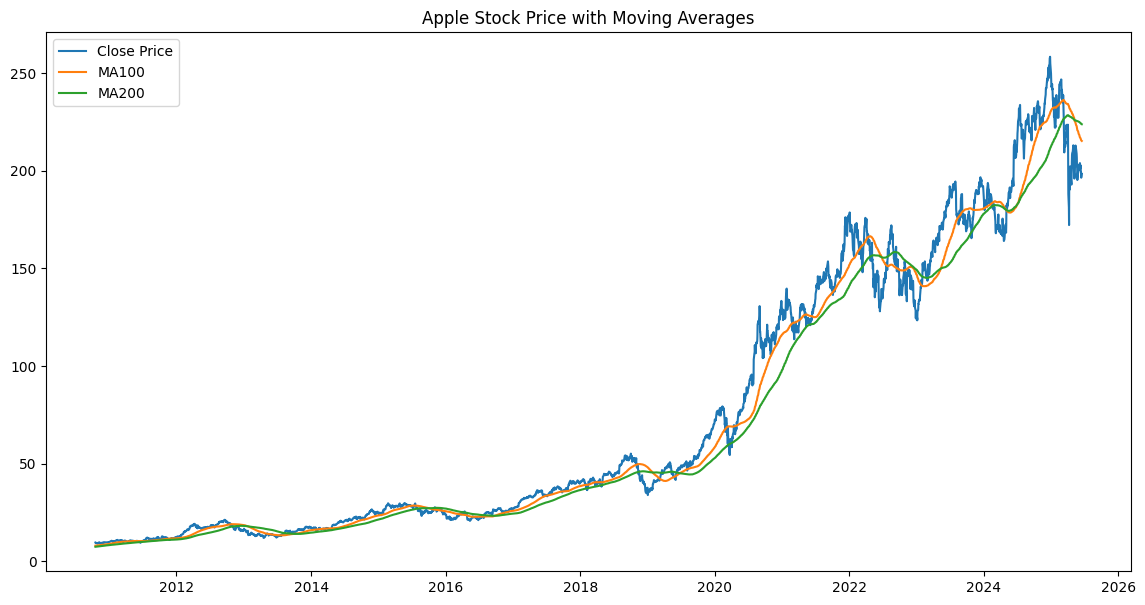

In [5]:
# Tracer les indicateurs techniques

# Définir la taille de la figure (largeur=14, hauteur=7)
plt.figure(figsize=(14,7))

# Tracer le prix de clôture de l'action Apple
plt.plot(df['Close'], label='Close Price')

# Tracer la moyenne mobile sur 100 jours
plt.plot(df['MA100'], label='MA100')

# Tracer la moyenne mobile sur 200 jours
plt.plot(df['MA200'], label='MA200')

# Afficher la légende des courbes
plt.legend()

# Ajouter un titre au graphique
plt.title('Apple Stock Price with Moving Averages')

# Afficher le graphique
plt.show()

In [6]:
# --------------------------
# PART 3: PREPARE DATA
# --------------------------

# Use 'Close', 'MA100', 'RSI', 'MACD' as features
features = df[['Close', 'MA100', 'RSI', 'MACD']]

In [7]:
# Diviser les données en deux ensembles : 80% pour l'entraînement, 20% pour le test

# Calcul de la taille de l'ensemble d'entraînement (80% des données)
train_size = int(len(features) * 0.8)

# Sélection des premières lignes pour l'entraînement
train_data = features.iloc[:train_size]

# Sélection des données pour le test à partir de (train_size - 100)
# On inclut un chevauchement de 100 jours pour permettre le calcul correct de la MA100
test_data = features.iloc[train_size - 100:][['Close', 'MA100', 'RSI', 'MACD']]


In [8]:
# Mise à l'échelle des données (normalisation entre 0 et 1)

# Créer un scaler MinMax qui convertira les valeurs dans la plage [0, 1]
scaler = MinMaxScaler(feature_range=(0,1))

# Appliquer l'entraînement du scaler uniquement sur les données d'entraînement
# Cela évite que des informations du test ne soient utilisées pendant l'entraînement (fuite de données)
scaled_train = scaler.fit_transform(train_data)

# Utiliser le scaler déjà entraîné pour transformer les données de test
scaled_test = scaler.transform(test_data)


In [9]:
# Créer des séquences de données pour entraîner le modèle LSTM

def create_sequences(data, seq_length=100):
    X, y = [], []  # X = séquences d'entrée, y = valeurs cibles
    for i in range(seq_length, len(data)):
        # Ajouter une séquence de longueur 'seq_length'
        X.append(data[i-seq_length:i])
        # Ajouter la valeur cible correspondante (prix de clôture à prédire)
        y.append(data[i, 0])  # On suppose que la première colonne est 'Close'
    return np.array(X), np.array(y)

# Créer les séquences pour l'entraînement
X_train, y_train = create_sequences(scaled_train)

# Créer les séquences pour le test
X_test, y_test = create_sequences(scaled_test)


In [10]:
# --------------------------
# PART 4: BUILD & TRAIN LSTM MODEL
# --------------------------

# Création du modèle LSTM en utilisant une architecture séquentielle
model = Sequential([

    # Première couche LSTM avec 100 neurones, retourne les séquences pour la couche suivante
    LSTM(100, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),

    # Dropout pour éviter le surapprentissage (désactive 20% des neurones aléatoirement)
    Dropout(0.2),

    # Deuxième couche LSTM avec 100 neurones, cette fois sans return_sequences (fin de la chaîne)
    LSTM(100),

    # Dropout de 20% après la deuxième couche LSTM
    Dropout(0.2),

    # Couche de sortie : une seule valeur prédite (le prix de clôture)
    Dense(1)
])

# Compilation du modèle : optimiseur 'adam' et fonction de perte 'mse' (erreur quadratique moyenne)
model.compile(optimizer='adam', loss='mse')


c:\Users\HP\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [11]:
# Entraîner le modèle avec une validation interne

history = model.fit(
    X_train,         # Données d'entrée d'entraînement (séquences)
    y_train,         # Valeurs cibles d'entraînement (prix de clôture)
    epochs=50,       # Nombre de passes complètes sur tout le jeu de données
    batch_size=32,   # Nombre d'échantillons traités avant mise à jour des poids
    validation_split=0.1,  # Utiliser 10% des données d'entraînement pour valider le modèle à chaque époque
    verbose=1        # Afficher la progression de l'entraînement dans la console
)


Epoch 1/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 10s 88ms/step - loss: 0.0100 - val_loss: 0.0029
Epoch 2/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 8s 103ms/step - loss: 7.5681e-04 - val_loss: 0.0011
Epoch 3/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 8s 95ms/step - loss: 5.7637e-04 - val_loss: 0.0012
Epoch 4/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 9s 83ms/step - loss: 6.6682e-04 - val_loss: 0.0030
Epoch 5/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 8s 94ms/step - loss: 6.6007e-04 - val_loss: 0.0011
Epoch 6/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 8s 93ms/step - loss: 4.5088e-04 - val_loss: 0.0020
Epoch 7/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 8s 95ms/step - loss: 4.8097e-04 - val_loss: 0.0035
Epoch 8/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 7s 86ms/step - loss: 5.4113e-04 - val_loss: 9.9921e-04
Epoch 9/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 7s 85ms/step - loss: 4.4222e-04 - val_loss: 9.7123e-04
Epoch 10/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 7s 89ms/step - loss: 5.9353e-04 - val_loss: 0.0016
Epoch 11/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 7s 85ms/step - loss: 4.2136e-04 - val_loss: 0.0015
Epoch 12/50
8

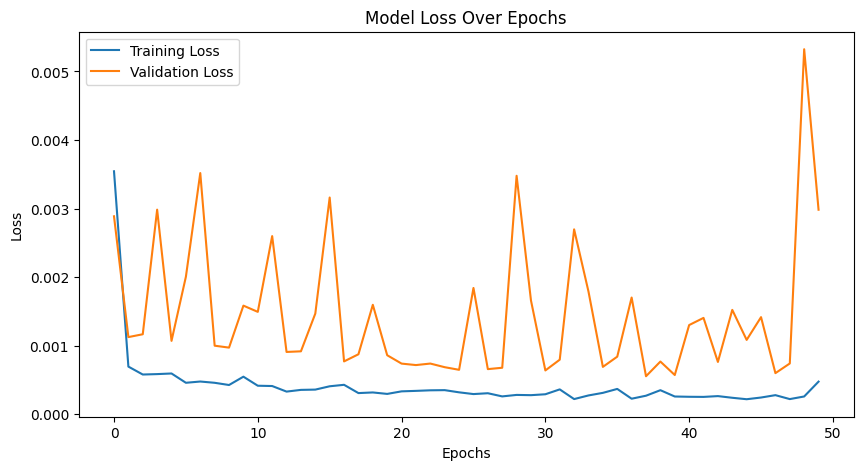

In [12]:
# Tracer la courbe de perte (loss) pendant l'entraînement du modèle

# Définir la taille de la figure (largeur=10, hauteur=5)
plt.figure(figsize=(10,5))

# Tracer la perte sur les données d'entraînement à chaque époque
plt.plot(history.history['loss'], label='Training Loss')

# Tracer la perte sur les données de validation à chaque époque
plt.plot(history.history['val_loss'], label='Validation Loss')

# Ajouter un titre au graphique
plt.title('Model Loss Over Epochs')

# Étiquette de l'axe des x
plt.xlabel('Epochs')

# Étiquette de l'axe des y
plt.ylabel('Loss')

# Afficher la légende des courbes
plt.legend()

# Afficher le graphique
plt.show()


In [13]:
# Save the model
model.save('apple_predictor.h5', save_format='h5')
print("Model saved as apple_predictor.h5")

Model saved as apple_predictor.h5


In [14]:
# --------------------------
# PART 5: EVALUATE MODEL
# --------------------------

# Predict on test data
y_pred = model.predict(X_test)

24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step


In [15]:
# Compléter les prédictions en ajoutant des zéros pour les 3 autres caractéristiques (features)

# Création d'un tableau de zéros de taille (nombre de prédictions, 4 features)
y_pred_padded = np.zeros((len(y_pred), 4))

# Placer les prédictions de la première feature (prix 'Close') dans la première colonne
y_pred_padded[:, 0] = y_pred.flatten()


In [16]:
# Revenir à l'échelle originale des prix (avant normalisation)

# Appliquer la transformation inverse du scaler sur les données complétées
# On récupère ensuite uniquement la première colonne (prix 'Close' réel)
y_pred_actual = scaler.inverse_transform(y_pred_padded)[:, 0]


In [17]:
# Compléter y_test en ajoutant des zéros pour les 3 autres features (comme pour les prédictions)

# Création d'un tableau de zéros de taille (nombre d'échantillons test, 4 features)
y_test_padded = np.zeros((len(y_test), 4))

# Placer les vraies valeurs de la première feature (prix 'Close') dans la première colonne
y_test_padded[:, 0] = y_test


In [18]:
# Revenir à l'échelle originale des prix réels de test (avant normalisation)

# Appliquer la transformation inverse du scaler sur les données complétées de test
# On récupère uniquement la première colonne (prix 'Close' réel)
y_test_actual = scaler.inverse_transform(y_test_padded)[:, 0]


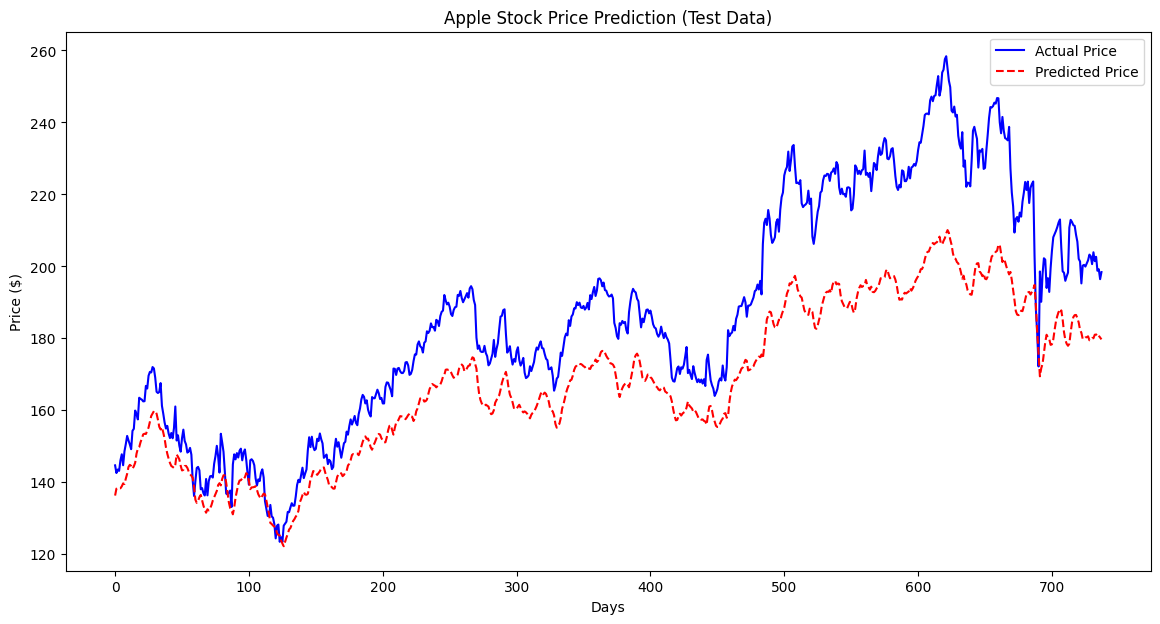

In [19]:
# Tracer les prix réels et prédits pour les données de test

# Définir la taille de la figure (largeur=14, hauteur=7)
plt.figure(figsize=(14,7))

# Tracer les prix réels (réels observés) en bleu
plt.plot(y_test_actual, label='Actual Price', color='blue')

# Tracer les prix prédits par le modèle en rouge avec un style en tirets
plt.plot(y_pred_actual, label='Predicted Price', color='red', linestyle='--')

# Ajouter un titre au graphique
plt.title('Apple Stock Price Prediction (Test Data)')

# Étiquette de l'axe des x (jours)
plt.xlabel('Days')

# Étiquette de l'axe des y (prix en dollars)
plt.ylabel('Price ($)')

# Afficher la légende des courbes
plt.legend()

# Afficher le graphique
plt.show()


In [20]:
# --------------------------
# PART 6: PREDICT FUTURE PRICES
# --------------------------

def predict_future(model, last_sequence, days=30):
    predictions = []  # Liste pour stocker les prédictions futures
    current_sequence = last_sequence.copy()  # Copier la dernière séquence connue pour ne pas modifier l'original
    
    for _ in range(days):
        # Prédire le prochain prix 'Close' à partir de la séquence actuelle
        next_pred = model.predict(current_sequence.reshape(1, 100, 4))[0, 0]
        predictions.append(next_pred)  # Ajouter la prédiction à la liste
        
        # Mettre à jour la séquence pour la prochaine prédiction :
        # Décaler la séquence d'un pas vers la gauche (retirer la valeur la plus ancienne)
        current_sequence = np.roll(current_sequence, -1, axis=0)
        
        # Placer la nouvelle prédiction à la fin de la séquence dans la colonne 'Close' (index 0)
        current_sequence[-1, 0] = next_pred
    
    # Compléter les prédictions en ajoutant des zéros pour les 3 autres indicateurs
    predictions_padded = np.zeros((len(predictions), 4))
    predictions_padded[:, 0] = predictions  # Remplir la colonne 'Close' avec les prédictions
    
    # Appliquer la transformation inverse pour obtenir les prix réels
    return scaler.inverse_transform(predictions_padded)[:, 0]


In [21]:
# Get last 100 days of test data
last_sequence = scaled_test[-100:]

In [22]:
# Predict next 30 days
future_prices = predict_future(model, last_sequence, days=30)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━

In [23]:
# Generate future dates
last_date = df.index[-1]
future_dates = [last_date + timedelta(days=i) for i in range(1, 31)]

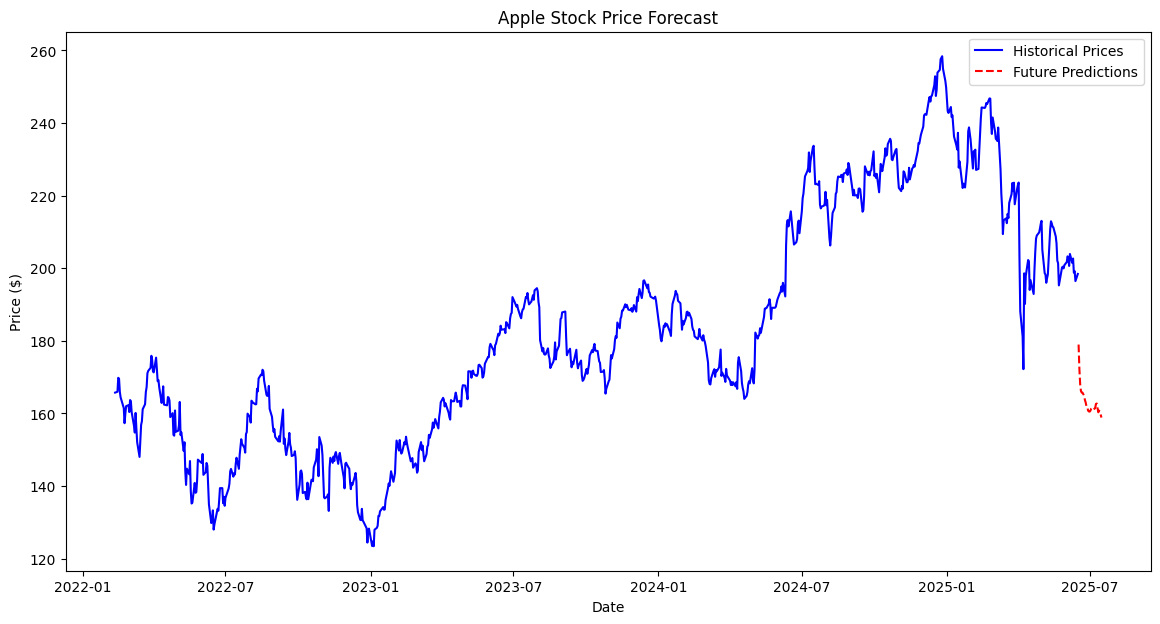

In [24]:
# Plot future predictions
plt.figure(figsize=(14,7))

# Pad the scaled_test[:, 0] with zeros for the other 3 features
scaled_test_padded = np.zeros((len(scaled_test), 4))
scaled_test_padded[:, 0] = scaled_test[:, 0]  # Add the 'Close' column

# Inverse transform to get actual prices
actual_prices = scaler.inverse_transform(scaled_test_padded)[:, 0]

# Adjust the index to include the 100-day overlap
adjusted_index = df.index[train_size - 100:]

# Plot historical prices
plt.plot(adjusted_index, actual_prices, 'b-', label='Historical Prices')

# Plot future predictions
plt.plot(future_dates, future_prices, 'r--', label='Future Predictions')

# Add labels and legend
plt.title('Apple Stock Price Forecast')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.legend()
plt.show()

In [25]:
# Afficher les prix futurs prédits dans un DataFrame pandas

future_df = pd.DataFrame({
    'Date': future_dates,           # Dates correspondantes aux jours futurs prédits
    'Predicted Price': future_prices  # Prix prédits pour ces dates
})

# Afficher ce tableau dans la console
print(future_df)


         Date  Predicted Price
0  2025-06-17       178.968254
1  2025-06-18       172.238310
2  2025-06-19       168.028375
3  2025-06-20       166.147467
4  2025-06-21       165.737676
5  2025-06-22       165.715859
6  2025-06-23       165.287122
7  2025-06-24       164.938253
8  2025-06-25       163.700520
9  2025-06-26       163.013488
10 2025-06-27       161.939332
11 2025-06-28       161.859727
12 2025-06-29       160.797652
13 2025-06-30       160.543077
14 2025-07-01       160.497927
15 2025-07-02       160.757668
16 2025-07-03       161.320986
17 2025-07-04       161.574145
18 2025-07-05       161.278292
19 2025-07-06       161.127029
20 2025-07-07       161.289352
21 2025-07-08       161.420052
22 2025-07-09       162.603950
23 2025-07-10       162.728452
24 2025-07-11       161.516327
25 2025-07-12       160.311209
26 2025-07-13       160.773995
27 2025-07-14       160.423347
28 2025-07-15       159.635045
29 2025-07-16       158.863070


In [ ]:
from sklearn.metrics import r2_score
import numpy as np

# Prédictions du modèle sur les données de test (normalisées)
y_pred_scaled = model.predict(X_test)

# Reconstruire des tableaux complets avec 4 colonnes (3 colonnes fictives à 0)
y_test_full = np.zeros((len(y_test), 4))
y_pred_full = np.zeros((len(y_pred_scaled), 4))

# Placer les vraies valeurs et les prédictions dans la première colonne (prix 'Close')
y_test_full[:, 0] = y_test
y_pred_full[:, 0] = y_pred_scaled[:, 0]

# Inverser la normalisation pour récupérer les valeurs réelles des prix
y_test_actual = scaler.inverse_transform(y_test_full)[:, 0]
y_pred_actual = scaler.inverse_transform(y_pred_full)[:, 0]

# Calcul du coefficient de détermination R² entre valeurs réelles et prédites
r2 = r2_score(y_test_actual, y_pred_actual)


# Commentaire sur la qualité du modèle :
# Un R² de 0.88 sur des données financières est considéré comme très bon,
# surtout vu la volatilité naturelle des marchés boursiers.


24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
